In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy
import csv
import copy
import time

In [2]:
n=10 #number of nodes of the graph
prob=0.3 #Edge density: Between 0 and 1
no_of_tran=1500 #number of transaction between each pair of sender and reciever
M_vector=numpy.array([5,10,20,50,100]) #Capacity of each link in the graph
numpy.random.seed(1)

BHnote: This notebook started out with [VM]'s Small Graph_Final.ipynb and is updated to use prices as in [SH] (Sakagiri - Hajek paper).   In addition to that the demand is deliberately made to not be a circulation.

$M$ in [VM] is the capacity of each link for each direction, so the total escrow amount for an edge in both directions is $2M.$  Thus $2M$ is same as $C$ in [SH].   The algorithm drops all demand which would make a balance get larger than M, so it keeps the backlog in each direction less than or equal to M. Thus, instead of queueing the transactions to have exact equal exchange in each direction, the transactions could be processed immediately by the usual method of the end users of the channel keeping track of the balances.  In the [VT] paper for a link $(u,v),$ if the queue sizes are $q_{(u,v)}$ and $q_{(v,u)}$ each in $[0,M]$ then an amount of transaction $s = \min\{ q_{(u,v)}, q_{(v,u)} \}$ could be locally cleared over the link.  Reducing both $q_{(u,v)}$ and $q_{(v,u)}$ by $s$ makes one of them zero.   The state $(q_{(u,v)}, q_{(v,u)} )$ in [VT] is equivalent to the channel having no queueing and total escrow amount $2M$ and the balance of escrow fund at $u$ being $x_{u,v} = M-q_{(u,v)} + q_{(v,u)},$ where $x$ is the state variable in [SH].    Therefore, in the code below, $x$ in [SH] is equivalent to:  $x_{u,v} = M - G[u][v] + G[v][u].$    So to minimize changes below uses G[i][j]["weight"] variables instead of $x$'s.

# Generate a Bidirected graph with specified # of nodes and edge density

Erdos Renyi Random Graph

In [3]:
# This cell is from Small Graph_Final.ipynb on [VT] github site.
numpy.random.seed(1)
random_G = nx.erdos_renyi_graph(n,prob) #Generate an Erdos Renyi Random Graph with n nodes and probability of an edge p
while nx.is_connected(random_G) == False:
  random_G = nx.erdos_renyi_graph(n,prob)   # Keep trying til a connected graph results
uni_edges=random_G.edges
numpy.savetxt('medium_graph.csv', (uni_edges), delimiter=',') #Saving the edges of the generated graph in a csv file

#Now, we will convert the graph into a bidirectional graph by adding edges in the opposite direction
rows=len(uni_edges) #Number of edges in the generated graph
col=2 #Source and Destination tuple of each edge
bi_edges=numpy.zeros((2*rows,col)) #double the number of edges of G
with open('medium_graph.csv') as csvDataFile: #Reading the csv file to import the edges of G
    p=csv.reader(csvDataFile)
    p=list(p)
    for i in range(0,col):
        for j in range(0,rows):
            bi_edges[j,i]=p[j][i]
    for i in range(0,col):
        for j in range(rows,2*rows):
            bi_edges[j,i]=bi_edges[j-rows,(i+1)%2] #Adding edges in the opposite direction
bi_edges=numpy.array(bi_edges)
bi_edges=bi_edges.astype(int)

#Generate a bidirectional graph with bi_edges
w=numpy.ones((2*rows))
bi_G = nx.DiGraph()
for i in range(0,2*rows):
    bi_G.add_weighted_edges_from([(bi_edges[i,0], bi_edges[i,1],w[i])]) #Adding bi_edges to the graph with weights w

# Generating Poisson Random Transaction Requests

- First, generate circular transaction rates
- Then, Generate no_of_tran Poisson Transaction requests between each pair of nodes with the specified rate
- Finally, randomize the order of transaction requests to generate the final data set


BHnote: Matrix P is the matrix of mean transaction **sizes.**   There are no_of_tran transactions betweem every pair or nodes.   Row and column sums would be 3n (30 for n=10) except the diagonal entries are set to zero.  The sizes of the transactions from $i$ to $j$ has the Poisson distribution with mean $P_{i,j}.$  In this modified code $P$ will be **not** be close to a circulation with $E[P_{i,j}] =4$ if $i < j$ and $E[P_{i,j} = 2$ if $i > j.$      


In [4]:
numpy.random.seed(1)
#Varaition of cell from Small Graph_Final.ipynb on [VT] github site, which adds 3n permuations to get P.
#Generating a transaction rate matrix such that about 2/3 of the demand is circulant
#Entries of P below diagonal have mean 2 and above diagonal have mean 4.
I=numpy.identity(n)
P=numpy.zeros((n,n))
for i in range(0,n*2):
    P=P+numpy.random.permutation(I)
P = numpy.triu(P, k=0)   # returns upper triangular matrix by zeroing out lower trianglar part
for i in range(0,n*2):
    P=P+numpy.random.permutation(I)
for i in range(0,n):
    P[i,i]=0
#Generating no_of_tran number of transactions between each pair of nodes
tran=numpy.array([0,11,1]) #initialize transaction array (this row will be deleted later)
for k in range(0,no_of_tran):
    for i in range(0,n):
        for j in range(0,n):
            if i!=j:
                x=numpy.random.poisson(P[i,j]) #Generating random transaction request from i to j
                if x>0:
                    New_tran=numpy.array([i,j,x]) #saving the new transaction as sender-reciever-value
                    tran=numpy.vstack((tran,New_tran)) #adding the new transaction to the list
tran=numpy.delete(tran,obj=0,axis=0) #deleting the first row
numpy.random.shuffle(tran) #shuffling the transaction order
print(P)

[[0. 2. 6. 3. 3. 4. 4. 3. 7. 5.]
 [2. 0. 1. 6. 6. 4. 3. 6. 3. 4.]
 [3. 2. 0. 5. 2. 7. 7. 4. 2. 2.]
 [1. 2. 4. 0. 4. 4. 5. 2. 4. 6.]
 [2. 2. 0. 2. 0. 3. 4. 5. 5. 3.]
 [6. 2. 2. 3. 3. 0. 2. 1. 4. 4.]
 [0. 3. 1. 4. 1. 3. 0. 2. 2. 5.]
 [2. 0. 4. 2. 4. 1. 3. 0. 3. 3.]
 [1. 2. 4. 0. 1. 1. 3. 5. 0. 4.]
 [2. 2. 1. 3. 2. 2. 2. 0. 4. 0.]]


# Finding the minimum weighted path in a given graph G from s to d

BHnote: minwp() and minwp-heu() are from [VT] code.   The variations minwp-SH() and minwp-SH() are very similar, but they return the min_wei_path and the variable var indicating whether there is enough capacity availble to route the transaction.
   

The minwp version is wouldn't work well for large networks because it involves enumeration of all paths from s to d.  Paths are given as tuples which list the nodes of the path including s and d.  Weights are in G[i][j]["weight"].   Uses weight in forward direction minus weight in backwards direction.   I think in running the main loop algorithm for each edge either one or the other of those is zero.

The variable s below represents how much weights in both directions could be reduced by clearing the smaller balance on the link.  I think that in running main loop s will typically be zero because the balance on at least one side will be zero.

It looks like the G weights are all about balance and not about congestion.


In [5]:
def minwp(G,s,d,tran):
    start_time=time.time()
    min_wei_path=0 #initialize the minimum weighted path to 0
    X=nx.all_simple_paths(G,s,d) #Enumerating all the paths from s to d
    weight2=1000 #Intitialize by a very big number
    for j, a in enumerate(X): #a is a path from s to d
        weight1=0 #Initialize to calculate weight of a
        for k in range(0,len(a)-1):
            weight1=weight1+G[a[k]][a[k+1]]['weight']-G[a[k+1]][a[k]]['weight'] #calculate the total weight of 'a'
        if min(weight1,weight2)==weight1 and weight1!=weight2: #compare with the best weight obtained so far
            min_wei_path=a #update the minimum weighted path
            weight2=weight1 #update the best weight obtained so far
    var=1
    for l in range(0,len(min_wei_path)-1):
        s=min(G[min_wei_path[l]][min_wei_path[l+1]]['weight'],G[min_wei_path[l+1]][min_wei_path[l]]['weight'],M)
        if G[min_wei_path[l]][min_wei_path[l+1]]['weight']+tran-s>M:
            #Checking if a has enough capacity to route tran
            var=0
    if var!=0:
        return (min_wei_path,time.time()-start_time) #We will either get a path from s to d or 0 if min_wei_path cannot route tran
    else:
        return (0,time.time()-start_time)

In [6]:
def minwp_SH(G,s,d,tran):   # This is a Sankagiri-Hajek (SH) modification of minwp
    start_time=time.time()
    min_wei_path=0 #initialize the minimum weighted path to 0
    X=nx.all_simple_paths(G,s,d) #Enumerating all the paths from s to d
    weight2=1000 #Intitialize by a very big number
    for j, a in enumerate(X): #a is a path from s to d
        weight1=0 #Initialize to calculate weight of a
        for k in range(0,len(a)-1):
            weight1=weight1+G[a[k]][a[k+1]]['price']-G[a[k+1]][a[k]]['price'] #calculate the total weight of 'a'
        if min(weight1,weight2)==weight1 and weight1!=weight2: #compare with the best weight obtained so far
            min_wei_path=a #update the minimum weighted path
            weight2=weight1 #update the best weight obtained so far
    var=1
    for l in range(0,len(min_wei_path)-1):
        s=min(G[min_wei_path[l]][min_wei_path[l+1]]['weight'],G[min_wei_path[l+1]][min_wei_path[l]]['weight'],M)
        if G[min_wei_path[l]][min_wei_path[l+1]]['weight']+tran-s>M:
            #Checking if min_wei_path has enough capacity to route tran
            var=0

    return (var, min_wei_path,time.time()-start_time) #Always return path, var indicates capacity exists for transaction


# Finding the minimum weighted path in a given graph G from s to d Heuristic

- Using the Heuristic: Find K- Shortest path using the positive part of the weights and pick the path among these which has the lowest total weight

In [7]:
def minwp_heu(G,s,d,tran,M,K):
    start_time=time.time()
    #X=nx.shortest_simple_paths(G,s,d,'imbalance')
    X=nx.shortest_simple_paths(G,s,d)
    #returns a generator which returns one path at a time from shortest to longest
    weight2=100000 #initialize by a very large number
    for j, path in enumerate(X): #enumerate shortest to longest paths
        weight1=0 #initialize by 0 to calculate the weight of path
        for k in range(0,len(path)-1):
            weight1=weight1+G[path[k]][path[k+1]]['weight']-G[path[k+1]][path[k]]['weight']
            #calculating the actual weight of path p
        if min(weight1,weight2)==weight1 and weight1!=weight2: #comparing with the best weight obtained so far
            min_wei_path=path #picking the minimum weight path
            weight2=weight1 #updating the best weight obtained so for
        if j == K-1: #break after looking at K shortest paths according to the imbalance
            break
    var=1
    for l in range(0,len(min_wei_path)-1):
        s=min(G[min_wei_path[l]][min_wei_path[l+1]]['weight'],G[min_wei_path[l+1]][min_wei_path[l]]['weight'],M)
        if G[min_wei_path[l]][min_wei_path[l+1]]['weight']+tran-s>M:
            #Checking if a has enough capacity to route tran
            var=0
    return (var, weight2, min_wei_path,time.time()-start_time)

In [8]:
def minwp_heu_SH(G,s,d,tran,M,K):
    start_time=time.time()
    X=nx.shortest_simple_paths(G,s,d, weight = None )
    #returns a generator which returns one path at a time from shortest to longest
    weight2=100000 #initialize by a very large number
    for j, path in enumerate(X): #enumerate shortest to longest paths
        weight1=0 #initialize by 0 to calculate the weight of path
        for k in range(0,len(path)-1):
            weight1=weight1+G[path[k]][path[k+1]]["price"]-G[path[k+1]][path[k]]["price"]   # Prices are negatives so didn't need to subtract
            #calculating the actual weight of path p
        if min(weight1,weight2)==weight1 and weight1!=weight2: #comparing with the best weight obtained so far
            min_wei_path=path #picking the minimum weight path
            weight2=weight1 #updating the best weight obtained so for
        if j == K-1: #break after looking at K shortest paths according to the imbalance
            break
    var=1
    for l in range(0,len(min_wei_path)-1):
        s=min(G[min_wei_path[l]][min_wei_path[l+1]]['weight'],G[min_wei_path[l+1]][min_wei_path[l]]['weight'],M)
        if G[min_wei_path[l]][min_wei_path[l+1]]['weight']+tran-s>M:
            #Checking if min_wei_path has enough capacity to route tran
            var=0
    return (var, weight2, min_wei_path, time.time()-start_time) # var indicates if path has capacity for tran, weight2 is path price

# Routing tran using path

In [9]:
def UpdateWeights(G,path,tran,M):
    for i in range(0,len(path)-1):
        s=min(G[path[i]][path[i+1]]['weight'],G[path[i+1]][path[i]]['weight'],M) #calculating the amount of service
        G[path[i]][path[i+1]]['weight']=G[path[i]][path[i+1]]['weight']+tran-s
        G[path[i+1]][path[i]]['weight']=G[path[i+1]][path[i]]['weight']-s
    return G

# Updating prices along path using tran (SH)

The following "UpdatePrices()" because in our work the prices can deviate from the balance differenes due to the on chain transactions.   Our paper has "congestion control" which means that we sometimes don't put a request through. <br><br>

The simulations of [VM] don't have any rebalancing -- it makes them more similar to simulations of others and avoids issues of how frequently to rebalance.   They take as a performance measure the fraction of transactions and the fraction of transaction amounts successfully routed. Paper [SH] dicusses rebalancing quite a bit, but to use the [VM] code and be similar to our model, we will simulate a version of our code that also does not rebalance.

The paper [SH] has a focus on utility maximization with utility functions $U_{i,j}$ such that $U_{i,j}(q)$ is the utility of routing quantity $q$ from $i$ to $j$ in one time slot.   To focus on total accepted number of transations accepted and to take into account the demand $a_{i,j}$ for a transaction from $i$ to $j$ we assume that $U_{i,j}(q) = \min\{a_{i,j},q\}\tau $  for all $i,j$, where $\tau$ is a positive constant.  If the total path price is $p$ per unit flow then the payoff for flow $i,j$ is maximized by requesting the transaction go through if $p \leq \tau$ and withhold the flow if $p \geq \tau.$   Thus, $\tau$ is the *path price threshold*    

So in the simulation, transaction requests are considered one at a time.   If $i$ and $j$ are the source and destination for the transaction request, we consider the $K$ paths from $i$ to $j$ and select the one with the smallest path price (sum of link prices along the path).  If the path price exceeds the path price threshold, the transaction is not routed and prices are not updated.

If the path price is less than the price threshold, then we check to see if there is sufficient capacity to route the transaction.   If yes the transaction is routed.   If not, the paper [SH] would force the transaction to be routed by forcing a rebalancing.  To approximate this, we do not count the transaction in the carried transactions.   Instead of rebalancing to a set point such as half of escrow in each side, we simply don't update the balances.   It is equivalent to a small rebalancing of just enough to carry the transaction.   But in this case, according to [SH], the prices of the links along the path are updated nevertheless less.

So the essential difference between the algorithm we simulate based on [SH] compared to the one in [VM] is that prices are maintaining on links and if the total path price is less than the path price threshold but there is not capacity to carry the transaction, then the prices along the path are nevertheless updated.

In [10]:
def UpdatePrices(G,path,tran):
    for i in range(0,len(path)-1):
        G[path[i]][path[i+1]]['price']= G[path[i]][path[i+1]]['price']+tran
        G[path[i+1]][path[i]]['price']= G[path[i+1]][path[i]]['price']-tran
    return G

# Main Loop [VM]

BHnote:  This is the same as the original code of [VM] with slight modification.  Namely, the called functions minwp() or minwp_heur() include the additional argument var.  <br><br>
This main loop code uses the function minwp_heu() defined below, so the code defining minwp_heu() should be run before main loop.  Or else minwp_heu() in the main loop could be changed to minwp() which is defined above and actually does find the minimum cost path.  The function minwp_heu has one more parameter -- namely K -- which is the number of shortest path using positive parts of weights -- to explore in the heuristic.  The code minwp() is about five times slower than minwp_heu() for the 10 node network.

In [11]:
for argument in range(0,len(M_vector)):
    M=M_vector[argument]
    K=2
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=0
    t=0
    total_time=0
    start_time=time.time()
    for k in range(0,len(bi_edges)):
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['imbalance']=0 #initializing the imbalance
    for i in range(0,len(tran)):
        #if min_wei_path!=0:
            #bi_G=UpdateWeights(bi_G,min_wei_path,0) #Balancing the outstanding balance from prev transaction
            #Ideally, you would clear out the buffer on all the edges but we do it only for the edges for which
            #there can be some outstanding balance to optimize the run time of the code
        (var,min_wei,min_wei_path,t)=minwp_heu(bi_G,tran[i,0],tran[i,1],float(tran[i,2]),M,K) #finding the minimum weighted path from sender to reciever
        total_time=total_time+t
        if var!=0: #If a path exists
            bi_G=UpdateWeights(bi_G,min_wei_path,tran[i,2],M) #Route the transaction using min_wei_path
            no_of_succ_tran=no_of_succ_tran+1
            amount_of_succ_tran=amount_of_succ_tran+tran[i,2]
    for i in range(0,len(bi_edges)):
        total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight']
    print("no_of_succ_tran:", no_of_succ_tran, "amount_of_succ_tran:", amount_of_succ_tran,
         "total_buffer:", total_buffer, "M:",M, "time:", total_time)

no_of_succ_tran: 60069 amount_of_succ_tran: 140568 total_buffer: 56.0 M: 5 time: 5.345667362213135
no_of_succ_tran: 78272 amount_of_succ_tran: 227415 total_buffer: 103.0 M: 10 time: 5.6695897579193115
no_of_succ_tran: 82463 amount_of_succ_tran: 250980 total_buffer: 195.0 M: 20 time: 4.849119424819946
no_of_succ_tran: 83500 amount_of_succ_tran: 257616 total_buffer: 490.0 M: 50 time: 4.810781240463257
no_of_succ_tran: 84483 amount_of_succ_tran: 261458 total_buffer: 999.0 M: 100 time: 4.700531482696533


# Main Loop (SH)

For simplicity and to make more similar to the [VM] code, we use the edgeweights of G to track what in our paper is x. They are related by $x_{u,v} = M - G[u][v] + G[v][u].$  In other words, if the G's were queued transaction amounts and if they were cleared to zero out one of them then $x_{u,v}$ would be the escrow balance at $u$.    Similarly, $x_{v,u} = M - G[v][u] + G[u][v].$  Note that $x_{u,v} + x_{v,u}=2M$.
<br><br>
  If there is not capacity for a transaction we will not accept the transaction but we will still update the price vector $Lamb$ if the path price was less than the path price threshold.   We also will not rebalance.  It is equivalent to rebalancing but just by enough to cover that one transaction.

In [12]:
for argument in range(0,len(M_vector)):
    M=M_vector[argument]
    K = 1
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=0
    var = 0
    t=0
    total_time=0
    path_price_threshold = 25
    start_time=time.time()
    for k in range(0,len(bi_edges)):
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['price']=0 #initializing the price
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['imbalance']=0 #initializing the imbalance
    for i in range(0,len(tran)):
        #if var!=0:
            #bi_G=UpdateWeights(bi_G,min_wei_path,0,M) #Balancing the outstanding balance from prev transaction
            #Ideally, you would clear out the buffer on all the edges but we do it only for the edges for which
            #there can be some outstanding balance to optimize the run time of the code
            #Except for clearing out small values 0.01/len(bi_edges) I don't think this is needed --BH
#
#       BHnote: The following was in the github code -- it is for the heuristic shortest path algorithm   Had K=1 in VM code.
        (var, path_price, min_wei_path,t)=minwp_heu_SH(bi_G,tran[i,0],tran[i,1],float(tran[i,2]),M,K) #find min weight path from sender to reciever

#       (var, min_wei_path,t)=minwp_SH(bi_G,tran[i,0],tran[i,1],float(tran[i,2])) #finding the minimum weighted path from sender to reciever
#
#
        total_time=total_time+t
        if path_price < path_price_threshold:
          if var!=0: #If path has enough capacity to handle transaction
             bi_G=UpdateWeights(bi_G,min_wei_path,tran[i,2],M) #Route the transaction using min_wei_path -- update weights
             no_of_succ_tran=no_of_succ_tran+1
             amount_of_succ_tran=amount_of_succ_tran+tran[i,2]
          bi_G=UpdatePrices(bi_G,min_wei_path,tran[i,2]) #Update prices whether or not transaction went through
    for i in range(0,len(bi_edges)):
        total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight']
    print("no_of_succ_tran:", no_of_succ_tran, "amount_of_succ_tran:", amount_of_succ_tran,
         "total_buffer:", total_buffer, "M:",M, "time:", total_time)

no_of_succ_tran: 40268 amount_of_succ_tran: 95020 total_buffer: 58.0 M: 5 time: 1.6771845817565918
no_of_succ_tran: 69788 amount_of_succ_tran: 210474 total_buffer: 87.0 M: 10 time: 1.732243537902832
no_of_succ_tran: 83303 amount_of_succ_tran: 270453 total_buffer: 155.0 M: 20 time: 1.6934702396392822
no_of_succ_tran: 85345 amount_of_succ_tran: 280664 total_buffer: 181.0 M: 50 time: 1.6370527744293213
no_of_succ_tran: 85345 amount_of_succ_tran: 280664 total_buffer: 181.0 M: 100 time: 1.6418635845184326


# Comparing [SH] algorithm with varying threshold to [VM] algorithm

In [13]:
def results_SH(M, path_price_threshold, K, bi_G,bi_edges,tran):
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=0
    var = 0
    for k in range(0,len(bi_edges)):
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['price']=0 #initializing the price
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['imbalance']=0 #initializing the imbalance
    for i in range(0,len(tran)):
        (var, path_price, min_wei_path,t)=minwp_heu_SH(bi_G,tran[i,0],tran[i,1],float(tran[i,2]),M, K) #find min weight path

#       (var, min_wei_path,t)=minwp_SH(bi_G,tran[i,0],tran[i,1],float(tran[i,2])) #finding the minimum weighted path from sender to reciever
        if path_price < path_price_threshold:
          if var!=0: #If path has enough capacity to handle transaction
             bi_G=UpdateWeights(bi_G,min_wei_path,tran[i,2],M) #Route the transaction using min_wei_path -- update weights
             no_of_succ_tran=no_of_succ_tran+1
             amount_of_succ_tran=amount_of_succ_tran+tran[i,2]
          bi_G=UpdatePrices(bi_G,min_wei_path,tran[i,2]) #Update prices whether or not trans went through
    for i in range(0,len(bi_edges)):
        total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight']
    return(no_of_succ_tran,amount_of_succ_tran)

In [14]:
def results_VM(M, K, bi_G,bi_edges,tran):
    no_of_succ_tran=0
    amount_of_succ_tran=0
    total_buffer=0
    min_wei_path=0
    var = 0
    for k in range(0,len(bi_edges)):
        bi_G[bi_edges[k,0]][bi_edges[k,1]]['weight']=0.01/len(bi_edges) #initializing the weights
    for i in range(0,len(tran)):
        (var, path_price, min_wei_path,t)=minwp_heu(bi_G,tran[i,0],tran[i,1],float(tran[i,2]),M, K) #find min weight path from sender to reciever
#       (var, min_wei_path,t)=minwp_SH(bi_G,tran[i,0],tran[i,1],float(tran[i,2])) #finding the minimum weighted path from sender to reciever
        if var!=0: #If path has enough capacity to handle transaction
            bi_G=UpdateWeights(bi_G,min_wei_path,tran[i,2],M) #Route the transaction using min_wei_path -- update weights
            no_of_succ_tran=no_of_succ_tran+1
            amount_of_succ_tran=amount_of_succ_tran+tran[i,2]
    for i in range(0,len(bi_edges)):
        total_buffer=total_buffer+bi_G[bi_edges[i,0]][bi_edges[i,1]]['weight']
    return(no_of_succ_tran,amount_of_succ_tran)

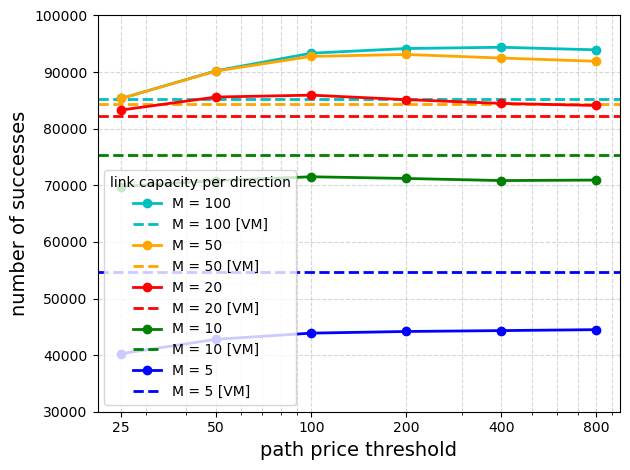

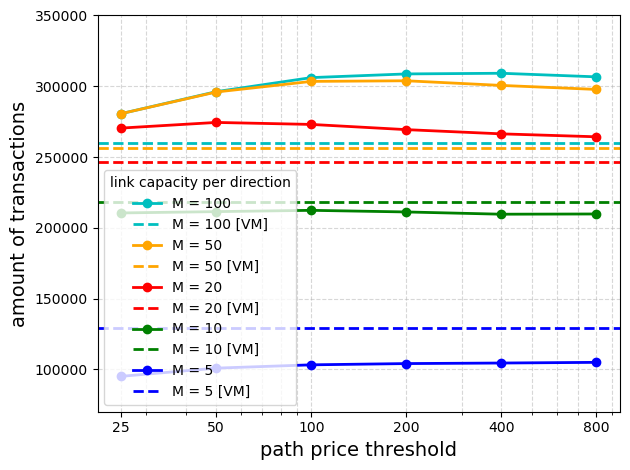

In [21]:
# M and path_price_threshold values used in plot
Ms   = [5, 10, 20, 50, 100]
taus = [25, 50, 100, 200, 400, 800]
K = 1


num_success_SH = numpy.zeros((len(Ms), len(taus)))
amount_SH      = numpy.zeros((len(Ms), len(taus)))
for i in range(len(Ms)):
  for j in range(len(taus)):
    num_success_SH[i][j], amount_SH[i][j] = results_SH(Ms[i], taus[j], K, bi_G, bi_edges, tran)

num_success_VM = numpy.zeros(len(Ms))
amount_VM      = numpy.zeros(len(Ms))
for i in range(len(Ms)):
    num_success_VM[i], amount_VM[i] = results_VM(Ms[i], K, bi_G, bi_edges, tran)

colors = ('b','g','r','orange','c', 'y' )

fig, ax = plt.subplots()

for i in range(len(Ms)-1, -1, -1):
    ax.plot(taus, num_success_SH[i,:],
             marker='o', lw=2, color = colors[i],
             label= "M = "  + str(Ms[i])  )
    ax.axhline( y = num_success_VM[i], linestyle= '--', color = colors[i],
             lw=2, label= "M = "  + str(Ms[i]) + " [VM]" )

ax.set_xscale('log')
ax.set_xticks(taus)
ax.set_xticklabels(taus)
ax.set_xlabel('path price threshold', fontsize=14)
ax.set_ylabel('number of successes', fontsize=14)
#ax.set_title(r'Number of successes vs path price threshold', fontsize=14)
ax.set_ylim(30000,100000)
plt.legend(title="link capacity per direction", loc = 'best')
plt.grid(which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("num_success_K=" + str(K) + ".png")
plt.show()


fig, ax = plt.subplots()

for i in range(len(Ms)-1, -1, -1):
    ax.plot(taus, amount_SH[i,:],
             marker='o', lw=2, color = colors[i],
             label= "M = "  + str(Ms[i])  )
    ax.axhline( y = amount_VM[i], linestyle= '--', color = colors[i],
             lw=2, label= "M = "  + str(Ms[i]) + " [VM]" )

ax.set_xscale('log')
ax.set_xticks(taus)
ax.set_xticklabels(taus)
ax.set_xlabel('path price threshold', fontsize=14)
ax.set_ylabel('amount of transactions', fontsize=14)
#ax.set_title(r'Number of successes vs path price threshold', fontsize=14)
ax.set_ylim(70000,350000)
plt.legend(title="link capacity per direction", loc = 'best')
plt.grid(which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("amount_K=" + str(K) + ".png")
plt.show()